<a href="https://colab.research.google.com/github/seraogianluca/mircv-exercises/blob/main/Exercise6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#MIRCV 2021
# Gianluca Serao

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import glob
import os
import numpy as np
import PIL

import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img

from IPython.display import display
from tqdm.notebook import tqdm

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC

np.random.seed(42)
tf.random.set_seed(42)

BASE_DIR = '/content/gdrive/My Drive/mircv2021/data/learning'
TRAIN_DATA_DIR = os.path.join(BASE_DIR, 'CNRPark')
TEST_DATA_DIR = os.path.join(BASE_DIR, 'CNRParkTest')

with open(os.path.join(BASE_DIR, "imagenet-classes.txt")) as f:
  CLASS_NAMES = f.read().splitlines()

# convert classnames 'free','busy' in numeric 0,1,...
MAPPING = {label: num for num, label in enumerate( ('free','busy') )} # create the mapping {'free': 0, 'busy': 1}
TEST_IMAGE = os.path.join(BASE_DIR, 'cat.jpg')

BATCH_SIZE = 32

# Classification using a pretrained model

we will use *MobileNetV2* -- a compact network pretrained on ImageNet (ILSVRC-2012) -- to classify an image.



In [3]:
model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=True
)

model.summary()

14540800/14536120 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________

In [4]:
print(model.input.shape)
print(model.output.shape)

input_size = model.input.shape[1:3]

(None, 224, 224, 3)
(None, 1000)


The pretrained MobileNetV2 accepts 224x224 float32 images with pixel values in the range \[-1, 1\].
Once we loaded the image into a uint8 numpy array, the line

> x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

converts it in float32 in the pixel range \[-1, 1\], that is equivalent to:

> x = (x / 127.5) - 1



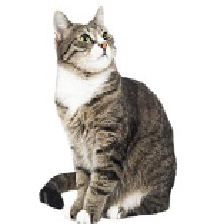

(1, 224, 224, 3)

In [5]:
pil_image = load_img(TEST_IMAGE, target_size=input_size)
display(pil_image)

np_image = np.array(pil_image)  # uint8, [0, 255]
x = tf.keras.applications.mobilenet_v2.preprocess_input(np_image)  # float32, [-1, 1]
x = np.expand_dims(x, axis=0)  # add batch dimension
x.shape

In [6]:
# classification with Tensorflow
predictions = model.predict(x)[0]  # there is only 1 image in the batch

# print the top 5 predictions
top5 = np.argsort(predictions)[::-1][:5]
top5_probabilities = predictions[top5]
for index, probability in zip(top5, top5_probabilities):
  print('{:.2f} {} (#{})'.format(probability, CLASS_NAMES[index], index))

0.85 tabby, tabby cat (#281)
0.05 Egyptian cat (#285)
0.02 tiger cat (#282)
0.01 lynx, catamount (#287)
0.00 Siamese cat, Siamese (#284)


# Transfer Learning on the CNRPark dataset

You will experiment with three ways to perform transfer learning from a pretrained network for the classification of a new dataset:


*   **A**  --  you will fix the bottom layers of a pretrained network and learn a new Multi-layer Perceptron (MLP) classifier on top of them.

*   **B**  -- you will extract features from the same fixed bottom layers and train a Support Vector Machine (SVM) classifier on them.

*   **C**  -- you will finetune all the layers of a pretrained network to learn to classify the new dataset.

The goal of this exercise is to implement, finetune, evaluate, and compare these methodologies.



## Data Loading (using tf.data API)

We use *image_dataset_from_directory()* provided by Keras to load the image dataset. The function returns a *tf.data.Dataset* object -- an abstraction that provides a way to iterate over data that might not fit entirely in main memory.

In [7]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DATA_DIR,
    subset="training",
    validation_split=0.2,
    seed=123,
    image_size=(224, 224),
    batch_size=BATCH_SIZE)

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DATA_DIR,
    subset="validation",
    shuffle=False,
    validation_split=0.2,
    seed=123,
    image_size=(224, 224),
    batch_size=BATCH_SIZE)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DATA_DIR,
    shuffle=False,
    image_size=(224, 224),
    batch_size=BATCH_SIZE)

# we define also a train data loader that does not shuffle data (useful for features extraction)
train_dataset_noshuf = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DATA_DIR,
    subset="training",
    shuffle=False,
    validation_split=0.2,
    seed=123,
    image_size=(224, 224),
    batch_size=BATCH_SIZE)

Found 328 files belonging to 2 classes.
Using 263 files for training.
Found 328 files belonging to 2 classes.
Using 65 files for validation.
Found 91 files belonging to 2 classes.
Found 328 files belonging to 2 classes.
Using 263 files for training.


Let's inspect what kind of data is returned by the streaming dataset:

(32, 224, 224, 3) (32,)
float32 0.0 255.0


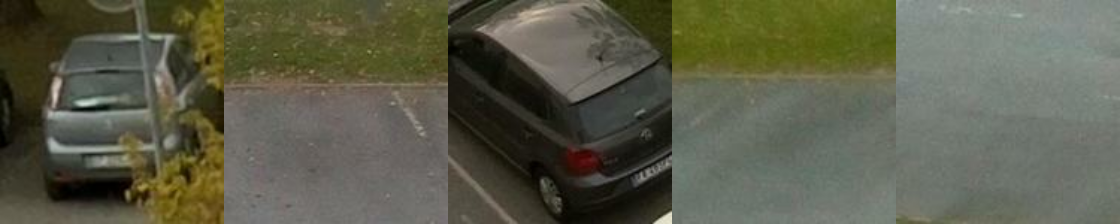

In [8]:
# get the first batch from the streaming dataset
batch = next(iter(train_dataset))  
images, labels = batch
print(images.shape, labels.shape)

# inspect data type
images = images.numpy()
print(images.dtype, images.min(), images.max())  # float32, [0, 255]

# show some images
sample_images = np.hstack(images[:5])  # stack 5 images horizontally
sample_images = sample_images.astype(np.uint8)  # PIL wants uint8
sample_images = PIL.Image.fromarray(sample_images)  # to PIL image
display(sample_images)  # show it

We use *.map()* to apply a preprocessing step to all the images in the dataset to match the desired format for MobileNetV2.

This will be executed lazily when we request a batch.

In [9]:
def preprocess(images, labels):
  # rescales from [0, 255] to [-1, 1], equivalent to:  images = (images / 127.5) - 1
  images = tf.keras.applications.mobilenet_v2.preprocess_input(images)
  return images, labels

# apply prepocessing to datasets (lazy operation)
train_dataset = train_dataset.map(preprocess, deterministic=True)
valid_dataset = valid_dataset.map(preprocess, deterministic=True)
test_dataset = test_dataset.map(preprocess, deterministic=True)

train_dataset_noshuf = train_dataset_noshuf.map(preprocess, deterministic=True)

In [10]:
# utility function that iterates a streaming dataset and collect all the labels (useful for sklearn functions)
def get_all_labels(dataset):
    labels_only = [labels.numpy() for _, labels in dataset]  # get labels only
    labels_only = np.concatenate(labels_only)  # concatenate all batches in a unique array
    return labels_only

## **Model A** -- Fixed pretrained layers + new fully-connected classifier on top

In [39]:
# TODO
# Build the model using MobileNetV2
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False  # do not include the pretrained layers implementing the imagenet classifier
)

# freezes weights of all levels of the pre-trained network
pretrained_model.trainable = False 

inputs = tf.keras.Input(shape=(224,224,3))
x = pretrained_model(inputs, training=False)
# Add a global average pooling
x = tf.keras.layers.GlobalAveragePooling2D(name='gap')(x)
# Add a FC level (Dense) of 256 neurons
x = tf.keras.layers.Dense(256, activation='relu', name='classifier_hidden')(x)
# Add binary output classification level
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# create an optimizer (RMSprop or Adam) and select a reasonable learning rate
# use the sparse_categorical_crossentropy loss
# use accuracy as evaluation metric
# configure the network with the chosen optimizer, loss, and metrics
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 1280)              0         
_________________________________________________________________
classifier_hidden (Dense)    (None, 256)               327936    
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 514       
Total params: 2,586,434
Trainable params: 328,450
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
# TODO
# Train the model for a reasonable number of epochs
model.fit(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    epochs=20, 
    validation_data=valid_dataset)


Epoch 1/20
9/9 [==============================] - 1s 77ms/step - loss: 2.1726e-04 - accuracy: 1.0000 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 2/20
9/9 [==============================] - 1s 70ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 3/20
9/9 [==============================] - 1s 71ms/step - loss: 6.6848e-05 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 4/20
9/9 [==============================] - 1s 71ms/step - loss: 4.6242e-05 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 5/20
9/9 [==============================] - 1s 70ms/step - loss: 3.5862e-05 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 6/20
9/9 [==============================] - 1s 70ms/step - loss: 2.1567e-05 - accuracy: 1.0000 - val_loss: 6.0551e-04 - val_accuracy: 1.0000
Epoch 7/20
9/9 [==============================] - 1s 71ms/step - loss: 1.9105e-05 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000

In [14]:
# evaluate the model on the test set with evaluate() ...
test_loss, test_accuracy = model.evaluate(test_dataset)
test_accuracy

3/3 [==============================] - 14s 5s/step - loss: 0.0867 - accuracy: 0.9780


0.9780219793319702

In [15]:
# ... or use predict() and sklearn to evaluate the model
test_predictions = model.predict(test_dataset)  # probabilities for all classes
test_predictions = np.argmax(test_predictions, axis=-1)  # index of the classes with largest probability

test_labels = get_all_labels(test_dataset)

m = confusion_matrix(test_labels, test_predictions)
print(m)
print( (m[0,0] + m[1,1]) / len(test_labels) ) 
print( accuracy_score(test_labels, test_predictions) )

[[44  0]
 [ 2 45]]
0.978021978021978
0.978021978021978


## **Model B** -- SVM on extracted features

In [16]:
# TODO
# build the feature extractor model from MobileNetV2
# same as model A add just a global average pooling
model_b = tf.keras.Sequential()
model_b.add(pretrained_model)
model_b.add(tf.keras.layers.GlobalAveragePooling2D())
model_b.summary()

# extract the feature from train, validation, and test
train_features = model_b.predict(train_dataset_noshuf, batch_size=BATCH_SIZE)
valid_features = model_b.predict(valid_dataset, batch_size=BATCH_SIZE)
test_features = model_b.predict(test_dataset, batch_size=BATCH_SIZE)

# and normalize them
train_features = sklearn.preprocessing.normalize(train_features)
valid_features = sklearn.preprocessing.normalize(valid_features)
test_features = sklearn.preprocessing.normalize(test_features)

# for train use the train_dataset_noshuf (to avoid shuffling)
# get also label vectors for training and evaluation with sklearn
train_labels = get_all_labels(train_dataset_noshuf)
valid_labels = get_all_labels(valid_dataset)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________


In [17]:
# TODO
# train SVMs: the C hyperparameter regularize the model (controls overfit)
# test various values of C in geometric progression and try to get the best accuracy on the validation set
C = []
scores = []
r = 0.5
a = 1.0

C = [a * (0.5 ** i) for i in range(5)]

for c in C:
  svm_classifier = sklearn.svm.LinearSVC(C=c)
  svm_classifier.fit(train_features, train_labels)
  scores.append(svm_classifier.score(valid_features,valid_labels))

result = zip(scores, C)
result = sorted(result, reverse=True)
print("C: ", C)
print("Sorted by score: ", result)

C_best = result[0][0]
svm_classifier = sklearn.svm.LinearSVC(C=C_best)
svm_classifier.fit(train_features, train_labels)
print("Validation accuracy: ", svm_classifier.score(valid_features,valid_labels))

C:  [1.0, 0.5, 0.25, 0.125, 0.0625]
Sorted by score:  [(1.0, 0.25), (1.0, 0.125), (0.9846153846153847, 1.0), (0.9846153846153847, 0.5), (0.9846153846153847, 0.0625)]
Validation accuracy:  0.9846153846153847


In [18]:
# evaluate the classifier on the test set
test_predictions = svm_classifier.predict(test_features)
m = confusion_matrix(test_labels, test_predictions)
print(m)
print(accuracy_score(test_labels, test_predictions))

[[44  0]
 [ 5 42]]
0.945054945054945


## **Model C** -- Finetune all layers of a pretrained network

In [40]:
# TODO
# Build the model with the MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False
)

base_model.trainable = True

model_finetune = tf.keras.Sequential()
model_finetune.add(base_model)
# Add a global average pooling
model_finetune.add(tf.keras.layers.GlobalAveragePooling2D(name='gap'))
# Add a binary output classification level
model_finetune.add(tf.keras.layers.Dense(2, activation='softmax'))
model_finetune.summary()

# create an optimizer (RMSprop or Adam) and select a reasonable learning rate
# use the sparse_categorical_crossentropy loss
# use accuracy as evaluation metric
# configure the network with the chosen optimizer, loss, and metrics
# train the network, tune the hyperparameters looking at the accuracy on the validation set
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5)
model_finetune.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_finetune.fit(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    epochs=10, 
    validation_data=valid_dataset)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 1280)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/10
9/9 [==============================] - 3s 301ms/step - loss: 0.6875 - accuracy: 0.6654 - val_loss: 0.6836 - val_accuracy: 0.6154
Epoch 2/10
9/9 [==============================] - 2s 220ms/step - loss: 0.4151 - accuracy: 0.7985 - val_loss: 0.5129 - val_accuracy: 0.7692
Epoch 3/10
9/9 [==============================] - 2s 222ms/step - loss: 0.2814 - accurac

In [34]:
# evaluate it on the test set
test_predictions = model_finetune.predict(test_dataset)  # probabilities for all classes
test_predictions = np.argmax(test_predictions, axis=-1)  # index of the class with largest probability

test_labels = get_all_labels(test_dataset)

print( confusion_matrix(test_labels, test_predictions) )
print( accuracy_score(test_labels, test_predictions) )

[[35  9]
 [ 1 46]]
0.8901098901098901


# **Retrieval Test**


In [35]:
n_queries = 5
k = 91

test_images, test_labels = zip(*test_dataset)
test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)
# np.concatenate([images for images, _ in test_dataset])  # get only the images

# query_indexes = [78, 80, 89, 23, 20]
# query_indexes = [14, 78, 79, 12, 18]
query_indexes = [14, 78,  2, 18,  9]
# query_indexes = np.random.choice(len(test_images), n_queries, replace=False)  # get 10 queries at random
query_images = test_images[query_indexes]
query_labels = test_labels[query_indexes]

In [36]:
# utility function to extract and normalize features
def extract_features(feature_extractor, images):
  features = feature_extractor.predict(images, batch_size=BATCH_SIZE)
  features = sklearn.preprocessing.normalize(features)
  return features

# utility function to perform kNN search
def search(query_features, db_features, k):
  scores = np.dot(query_features, db_features.T)  # compute cosine scores
  ranks = np.argsort(-scores, axis=1)  # order for descending score (NOTE the minus sign)

  topk = ranks[:, :k]  # get the top-k indices for each query
  n_queries = len(query_features)
  topk_scores = scores[np.arange(n_queries).reshape(-1, 1), topk]  # get the top-k scores for each query
  return topk, topk_scores

# utility to resize, pad, and write score on images
preview_size = 80
def process_images(image, score, is_relevant):
  # to uint8 [0, 255]
  image = ((image + 1) * 127.5).astype(np.uint8)

  # add a red/green flag
  color = (0, 255, 0) if is_relevant else (255, 0, 0)
  flag = np.full((10, 224, 3), fill_value=color, dtype=image.dtype)
  image = np.concatenate((image, flag), axis=0)

  # resize
  image = Image.fromarray(image).convert('RGBA')
  image.thumbnail((preview_size, preview_size))  # use PIL to resize the image

  # draw score
  draw = ImageDraw.Draw(image)
  draw.text((3, preview_size - 12), f'{score:.2f}', anchor='lt', fill=(255, 255, 255, 255))

  # pad the image with transparency
  image = ImageOps.expand(image, 5, fill=(0, 0, 0, 0))
  image = np.array(image)
  return image

# use np.vectorize to apply custom functions to numpy arrays
np_process_image = np.vectorize(process_images, signature='(h,w,c),(),()->(h1,w1,c1)')

# utility function to draw knn results for multiple queries
def show_results(images, scores, is_relevant):
  # images has shape (n_queries, k, H, W, C)
  images = np_process_image(images, scores, is_relevant)
  images = np.concatenate(images, axis=1)  # concatenate queries vertically
  images = np.concatenate(images, axis=1)  # concatenate results horizontally
  display(Image.fromarray(images))

In [37]:
def evaluate_knn_search(model, query_images, query_labels, db_images, db_labels, k):
  query_features = extract_features(model, query_images)
  db_features = extract_features(model, db_images)

  query_labels = query_labels.reshape(-1, 1)  # reshape to use numpy broadcasting

  topk, topk_scores = search(query_features, db_features, k)
  # topk_images = db_images[topk]
  topk_labels = db_labels[topk]
  topk_is_relevant = topk_labels == query_labels

  aps = [sklearn.metrics.average_precision_score(l, s) for l,s in zip(topk_is_relevant, topk_scores)]
  print('APs per Query:', aps)
  print('mAP:', np.mean(aps))

  # show_results(topk_images, topk_scores, topk_is_relevant)


In [41]:
pretrained_feature_extractor = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, pooling='avg')
new_classifier_feature_extractor = Model(inputs=model.input, outputs=model.get_layer('classifier_hidden').output)
finetuned_feature_extractor = Model(inputs=model_finetune.input, outputs=model_finetune.get_layer('gap').output)

print('\nModel pretrained on ImageNet (GAP)')
evaluate_knn_search(pretrained_feature_extractor, query_images, query_labels, test_images, test_labels, k)

print('\nModel frozen with top trained on CNRPark (Classifier Hidden 256D)')
evaluate_knn_search(new_classifier_feature_extractor, query_images, query_labels, test_images, test_labels, k)

print('\nModel finetuned on CNRPark (GAP)')
evaluate_knn_search(finetuned_feature_extractor, query_images, query_labels, test_images, test_labels, k)


Model pretrained on ImageNet (GAP)
APs per Query: [0.6320484345541635, 0.8070439461339773, 0.9025582136656385, 0.8737524776979021, 0.8364106875875879]
mAP: 0.8103627519278538

Model frozen with top trained on CNRPark (Classifier Hidden 256D)
APs per Query: [0.6032928956956916, 0.818902498699983, 0.9558744944968354, 0.8440209220779287, 0.9508131948672277]
mAP: 0.8345808011675333

Model finetuned on CNRPark (GAP)
APs per Query: [0.7975173026273593, 0.6795157409882817, 0.8763499225057051, 0.9418374719707747, 0.8239227473192912]
mAP: 0.8238286370822824
